### This notebook generate the line benefits from the operational cost

In [1]:
# libraries
import os
import time
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
# from kneed import KneeLocator
from pyomo.environ      import *
from pyomo.opt          import SolverFactory

In [2]:
#%% Defining the clustering functions
def KMeansMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmeans_pca = KMeans(n_clusters=OptClusters, init='k-means++', random_state=42)
    kmeans_pca.fit(Y_sklearn)
    df_segm_pca_kmeans = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmeans.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmeans.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmeans_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-means PCA'] = kmeans_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Scenario', 'Period', 'Day', 'Month', 'Segment K-means PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-means PCA'] = np.where(data['Variable'] == df['Variable'],
                                                    df['Segment K-means PCA'], df['Segment K-means PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 1
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-means PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                       5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9',
                                                                       9: 'st10',
                                                                       10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14',
                                                                       14: 'st15',
                                                                       15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19',
                                                                       19: 'st20',
                                                                       20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24',
                                                                       24: 'st25',
                                                                       25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29',
                                                                       29: 'st30',
                                                                       30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34',
                                                                       34: 'st35',
                                                                       35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39',
                                                                       39: 'st40',
                                                                       40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44',
                                                                       44: 'st45',
                                                                       45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49',
                                                                       49: 'st50'})
    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    data = data[
        ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # TableToFile['Duration'] = 1
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa / 24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)


def KMedoidsMethod(OptClusters, Y_sklearn, _path_0, _path_1, CaseName_0, CaseName_1, table, data):
    # Running the K-means with the optimal number of clusters. Setting up the initializer and random state.
    kmedoids_pca = KMedoids(metric="euclidean", n_clusters=OptClusters, init="heuristic", max_iter=2, random_state=42)
    kmedoids_pca.fit(Y_sklearn)
    df_segm_pca_kmedoids = pd.concat([table.reset_index(drop=True), pd.DataFrame(Y_sklearn)], axis=1)
    df_segm_pca_kmedoids.columns.values[-3:] = ['Component 1', 'Component 2', 'Component 3']
    df_segm_pca_kmedoids['Segment K-medoids PCA'] = kmedoids_pca.labels_
    # Saving the cluster on the NetworkCommitment CSV file
    df_segm_pca_kmedoids.to_csv(_path_0 + '/oT_Result_NetworkCommitment_ReducedCost_Clusters_kmedoids_' + CaseName_0 + '.csv', sep=',')
    # Storing clusters in the first table
    table['Segment K-medoids PCA'] = kmedoids_pca.labels_
    table = table.reset_index()
    table = table.set_index(['Day', 'Month', 'Segment K-medoids PCA'])
    # Stacking the table to also have the lines as index
    df = table.stack()
    df = df.reset_index()
    # Adding a new column with the cluster for each LoadLevel
    data['Segment K-medoids PCA'] = np.where(data['Variable'] == df['Variable'], df['Segment K-medoids PCA'], df['Segment K-medoids PCA'])
    # Adding the duration to each LoadLevel
    data['Duration'] = 0
    # Renaming the cluster with respective name adopting in openTEPES project
    data['Stage'] = data['Segment K-medoids PCA'].map({0: 'st1', 1: 'st2', 2: 'st3', 3: 'st4', 4: 'st5',
                                                                         5: 'st6', 6: 'st7', 7: 'st8', 8: 'st9', 9: 'st10',
                                                                         10: 'st11', 11: 'st12', 12: 'st13', 13: 'st14', 14: 'st15',
                                                                         15: 'st16', 16: 'st17', 17: 'st18', 18: 'st19', 19: 'st20',
                                                                         20: 'st21', 21: 'st22', 22: 'st23', 23: 'st24', 24: 'st25',
                                                                         25: 'st26', 26: 'st27', 27: 'st28', 28: 'st29', 29: 'st30',
                                                                         30: 'st31', 31: 'st32', 32: 'st33', 33: 'st34', 34: 'st35',
                                                                         35: 'st36', 36: 'st37', 37: 'st38', 38: 'st39', 39: 'st40',
                                                                         40: 'st41', 41: 'st42', 42: 'st43', 43: 'st44', 44: 'st45',
                                                                         45: 'st46', 46: 'st47', 47: 'st48', 48: 'st49', 49: 'st50',
                                                                         50: 'st51', 51: 'st52', 52: 'st53', 53: 'st54', 54: 'st55',
                                                                         55: 'st56', 56: 'st57', 57: 'st58', 58: 'st59', 59: 'st60',
                                                                         60: 'st61', 61: 'st62', 62: 'st63', 63: 'st64', 64: 'st65',
                                                                         65: 'st66', 66: 'st67', 67: 'st68', 68: 'st69', 69: 'st70',
                                                                         70: 'st71', 71: 'st72', 72: 'st73', 73: 'st74', 74: 'st75',
                                                                         75: 'st76', 76: 'st77', 77: 'st78', 78: 'st79', 79: 'st80',
                                                                         80: 'st81', 81: 'st82', 82: 'st83', 83: 'st84', 84: 'st85',
                                                                         85: 'st86', 86: 'st87', 87: 'st88', 88: 'st89', 89: 'st90',
                                                                         90: 'st91', 91: 'st92', 92: 'st93', 93: 'st94', 94: 'st95',
                                                                         95: 'st96', 96: 'st97', 97: 'st98', 98: 'st99', 99: 'st100',
                                                                         100: 'st101', 101: 'st102', 102: 'st103', 103: 'st104', 104: 'st105',
                                                                         105: 'st106', 106: 'st107', 107: 'st108', 108: 'st109', 109: 'st110',
                                                                         110: 'st111', 111: 'st112', 112: 'st113', 113: 'st114', 114: 'st115',
                                                                         115: 'st116', 116: 'st117', 117: 'st118', 118: 'st119', 119: 'st120',
                                                                         120: 'st121', 121: 'st122', 122: 'st123', 123: 'st124', 124: 'st125',
                                                                         125: 'st126', 126: 'st127', 127: 'st128', 128: 'st129', 129: 'st130',
                                                                         130: 'st131', 131: 'st132', 132: 'st133', 133: 'st134', 134: 'st135',
                                                                         135: 'st136', 136: 'st137', 137: 'st138', 138: 'st139', 139: 'st140',
                                                                         140: 'st141', 141: 'st142', 142: 'st143', 143: 'st144', 144: 'st145',
                                                                         145: 'st146', 146: 'st147', 147: 'st148', 148: 'st149', 149: 'st150'})

    #
    idx = kmedoids_pca.medoid_indices_
    dfDayToStage = pd.DataFrame(idx, columns=['Day'])
    dfDayToStage = dfDayToStage + 1
    for k in dfDayToStage.index:
        data.loc[data['Day'] == dfDayToStage['Day'][k], 'Duration'] = 1

    # Getting only the relevant information to build the new CSV file in CaseName_ByStages
    # data = data[
        # ['Scenario', 'Period', 'LoadLevel', 'Stage', 'InitialNode', 'FinalNode', 'Circuit', 'Duration', 'Value']]
    data = data[
        ['LoadLevel', 'Stage', 'Execution', 'Duration', 'Value']]
    data.to_csv(_path_0 + '/oT_Test_ReducedCost_Clusters_' + CaseName_0 + '.csv', sep=',')
    # Shaping the dataframe to be saved in CSV files
    # TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
    #                              columns=['InitialNode', 'FinalNode', 'Circuit'], fill_value=0)
    TableToFile = pd.pivot_table(data, values='Value', index=['LoadLevel', 'Stage', 'Duration'],
                                 columns=['Execution'], fill_value=0)
    TableToFile = TableToFile.reset_index()
    # Creating the dataframe to generate oT_Data_Duration
    dfDuration = pd.DataFrame(0, index=TableToFile.index, columns=['LoadLevel', 'Duration', 'Stage'])
    dfDuration['LoadLevel'] = TableToFile['LoadLevel']
    dfDuration['Duration'] = TableToFile['Duration']
    dfDuration['Stage'] = TableToFile['Stage']
    dfDuration.to_csv(_path_1 + '/oT_Data_Duration_' + CaseName_1 + '.csv', sep=',', index=False)
    # Identifying the Stages
    Stages = dfDuration.Stage.unique()
    Stages = np.sort(Stages)
    # Creating the dataframe to generate oT_Data_Stages
    dfa = pd.DataFrame({'Weight': dfDuration['Stage']})
    dfa = dfa['Weight'].value_counts()
    dfa = dfa/24
    dfa = dfa.sort_index()
    dfStages = pd.DataFrame(dfa.values, index=dfa.index, columns=['Weight'])
    dfStages.to_csv(_path_1 + '/oT_Data_Stage_' + CaseName_1 + '.csv', sep=',')
    # Creating the dataframe to generate oT_Dict_Stages
    dict_Stages = pd.DataFrame(Stages, columns=['Stage'])
    dict_Stages.to_csv(_path_1 + '/oT_Dict_Stage_' + CaseName_1 + '.csv', sep=',', index=False)

    return kmedoids_pca

### Reading the data for clustering

In [3]:
#%% Setting up the path a cases
DirName  = os.getcwd()

# CSV_name =  'OC_fy_(3, 1)h_64e_0.000625lr_0dor_0np_Truero_64bs_0.0ill_TrueMAE'
# CSV_name =  'OC_fy_(3, 2)h_64e_0.0025lr_0dor_0np_Truero_64bs_0.16ill_TrueMAE'
CSV_name =  'OC_fy_(3, 2)h_64e_0.000625lr_0dor_0np_Truero_64bs_0.0ill_TrueMAE'

CaseName_Base     = 'RTS24'
CaseName_ByStages = 'RTS24_'+CSV_name

_path_0 = os.path.join(DirName, CaseName_Base)
_path_1 = os.path.join(DirName, CaseName_ByStages)

StartTime = time.time()

#%% Selecting the maximum number of cluster to plot
max_cluster = 300
#%% Selecting the optimal number of cluster and defining the clustering method (0: k-means; 1:k-medoids)
# opt_cluster = 150
cluster_method = 1

output_directory = DirName + '/' + CaseName_ByStages + '/'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)


In [4]:
df_1 = pd.read_csv('Estimated_'+CSV_name+'.csv', index_col=0)

In [5]:
# Assuming your DataFrame is named df
# Calculate the difference for each column
diff_df_1 = df_1.drop(columns=["Network_Existing_Generation_Full"]).subtract(df_1["Network_Existing_Generation_Full"], axis=0)

In [6]:

#%% Loading Sets from CSV
dictSets = DataPortal()
dictSets.load(filename=_path_0+'/1.Set'+'/oT_Dict_LoadLevel_'   +CaseName_Base+'.csv', set='n'   , format='set')

#### Line benefits

In [7]:
diff_df_1.head()

,Network_Line_In_N_101_N_102_cac1,Network_Line_In_N_101_N_103_cac1,Network_Line_In_N_101_N_105_cac1,Network_Line_In_N_102_N_104_cac1,Network_Line_In_N_102_N_106_cac1,Network_Line_In_N_103_N_109_cac1,Network_Line_In_N_103_N_124_cac1,Network_Line_In_N_104_N_109_cac1,Network_Line_In_N_105_N_110_cac1,Network_Line_In_N_106_N_108_cac1,...,Network_Line_In_N_116_N_119_cac1,Network_Line_In_N_117_N_118_cac1,Network_Line_In_N_117_N_122_cac1,Network_Line_In_N_118_N_121_cac1,Network_Line_In_N_118_N_121_cac2,Network_Line_In_N_119_N_120_cac1,Network_Line_In_N_119_N_120_cac2,Network_Line_In_N_120_N_123_cac1,Network_Line_In_N_120_N_123_cac2,Network_Line_In_N_121_N_122_cac1
0,-0.000017,-0.000010,-0.000007,0.000007,-0.000006,0.000009,0.000017,-0.000010,0.000022,-0.000011,...,-0.000023,9.611250e-07,0.000003,-4.097819e-06,-0.000010,-7.107853e-06,-0.000012,0.000003,0.000010,-0.000008
1,-0.000017,-0.000010,-0.000007,0.000007,-0.000006,0.000009,0.000017,-0.000010,0.000022,-0.000011,...,-0.000023,8.344650e-07,0.000003,-4.023313e-06,-0.000010,-7.025897e-06,-0.000012,0.000003,0.000010,-0.000008
2,-0.000016,-0.000011,-0.000008,0.000005,-0.000001,0.000016,0.000019,-0.000010,0.000024,-0.000011,...,-0.000021,-1.579520e-06,0.000005,-2.466140e-06,-0.000009,-5.193053e-06,-0.000010,0.000005,0.000015,-0.000005
3,-0.000011,-0.000010,-0.000002,0.000004,0.000008,0.000031,0.000035,-0.000010,0.000040,0.000003,...,-0.000014,-2.577901e-06,0.000010,-4.172330e-07,-0.000004,5.811450e-07,-0.000005,0.000010,0.000028,0.000005
4,-0.000135,0.000111,0.000065,0.000031,-0.000261,-0.000068,0.000052,-0.000092,0.000122,0.000188,...,0.000081,2.072750e-05,-0.000407,-1.890511e-04,-0.000312,-1.288951e-04,-0.000256,-0.000017,-0.000031,-0.000284


In [8]:
diff_df_1['LoadLevel'] = dictSets['n' ]
diff_df_1.set_index('LoadLevel', inplace=True)

In [9]:
diff_df_1.head()

,Network_Line_In_N_101_N_102_cac1,Network_Line_In_N_101_N_103_cac1,Network_Line_In_N_101_N_105_cac1,Network_Line_In_N_102_N_104_cac1,Network_Line_In_N_102_N_106_cac1,Network_Line_In_N_103_N_109_cac1,Network_Line_In_N_103_N_124_cac1,Network_Line_In_N_104_N_109_cac1,Network_Line_In_N_105_N_110_cac1,Network_Line_In_N_106_N_108_cac1,...,Network_Line_In_N_116_N_119_cac1,Network_Line_In_N_117_N_118_cac1,Network_Line_In_N_117_N_122_cac1,Network_Line_In_N_118_N_121_cac1,Network_Line_In_N_118_N_121_cac2,Network_Line_In_N_119_N_120_cac1,Network_Line_In_N_119_N_120_cac2,Network_Line_In_N_120_N_123_cac1,Network_Line_In_N_120_N_123_cac2,Network_Line_In_N_121_N_122_cac1
LoadLevel,,,,,,,,,,,,,,,,,,,,,
01-01 00:00:00+01:00,-0.000017,-0.000010,-0.000007,0.000007,-0.000006,0.000009,0.000017,-0.000010,0.000022,-0.000011,...,-0.000023,9.611250e-07,0.000003,-4.097819e-06,-0.000010,-7.107853e-06,-0.000012,0.000003,0.000010,-0.000008
01-01 01:00:00+01:00,-0.000017,-0.000010,-0.000007,0.000007,-0.000006,0.000009,0.000017,-0.000010,0.000022,-0.000011,...,-0.000023,8.344650e-07,0.000003,-4.023313e-06,-0.000010,-7.025897e-06,-0.000012,0.000003,0.000010,-0.000008
01-01 02:00:00+01:00,-0.000016,-0.000011,-0.000008,0.000005,-0.000001,0.000016,0.000019,-0.000010,0.000024,-0.000011,...,-0.000021,-1.579520e-06,0.000005,-2.466140e-06,-0.000009,-5.193053e-06,-0.000010,0.000005,0.000015,-0.000005
01-01 03:00:00+01:00,-0.000011,-0.000010,-0.000002,0.000004,0.000008,0.000031,0.000035,-0.000010,0.000040,0.000003,...,-0.000014,-2.577901e-06,0.000010,-4.172330e-07,-0.000004,5.811450e-07,-0.000005,0.000010,0.000028,0.000005
01-01 04:00:00+01:00,-0.000135,0.000111,0.000065,0.000031,-0.000261,-0.000068,0.000052,-0.000092,0.000122,0.000188,...,0.000081,2.072750e-05,-0.000407,-1.890511e-04,-0.000312,-1.288951e-04,-0.000256,-0.000017,-0.000031,-0.000284


In [10]:
ddf_1 = diff_df_1.stack()

In [11]:
ddf_1.index.names = ['LoadLevel', 'Execution']

In [12]:
# changing the column name
ddf_1 = ddf_1.to_frame(name='Value')

In [13]:
ddf_1.head()

Value
LoadLevel            Execution                                 
01-01 00:00:00+01:00 Network_Line_In_N_101_N_102_cac1 -0.000017
                     Network_Line_In_N_101_N_103_cac1 -0.000010
                     Network_Line_In_N_101_N_105_cac1 -0.000007
                     Network_Line_In_N_102_N_104_cac1  0.000007
                     Network_Line_In_N_102_N_106_cac1 -0.000006

In [14]:
ddf_1 = ddf_1.reset_index()

In [15]:
ddf_1['Date'] = ddf_1['LoadLevel']
ddf_1['Date'] = ddf_1['Date'].str.slice(0, -6)

In [16]:
ddf_1['Date'] = pd.to_datetime(ddf_1['Date'], format='%m-%d %H:%M:%S', errors='coerce')

In [17]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date
340699,12-30 23:00:00+01:00,Network_Line_In_N_119_N_120_cac1,-0.000007,1900-12-30 23:00:00
340700,12-30 23:00:00+01:00,Network_Line_In_N_119_N_120_cac2,-0.000012,1900-12-30 23:00:00
340701,12-30 23:00:00+01:00,Network_Line_In_N_120_N_123_cac1,0.000003,1900-12-30 23:00:00
340702,12-30 23:00:00+01:00,Network_Line_In_N_120_N_123_cac2,0.000011,1900-12-30 23:00:00
340703,12-30 23:00:00+01:00,Network_Line_In_N_121_N_122_cac1,-0.000007,1900-12-30 23:00:00


#### Getting day of year and month

In [18]:
ddf_1['Hour' ] = ddf_1['Date'].dt.hour
ddf_1['Day'  ] = ddf_1['Date'].dt.dayofyear
ddf_1['Week' ] = ddf_1['Date'].dt.isocalendar().week
ddf_1['Month'] = ddf_1['Date'].dt.month

In [19]:
ddf_1.head()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month
0,01-01 00:00:00+01:00,Network_Line_In_N_101_N_102_cac1,-0.000017,1900-01-01,0,1,1,1
1,01-01 00:00:00+01:00,Network_Line_In_N_101_N_103_cac1,-0.000010,1900-01-01,0,1,1,1
2,01-01 00:00:00+01:00,Network_Line_In_N_101_N_105_cac1,-0.000007,1900-01-01,0,1,1,1
3,01-01 00:00:00+01:00,Network_Line_In_N_102_N_104_cac1,0.000007,1900-01-01,0,1,1,1
4,01-01 00:00:00+01:00,Network_Line_In_N_102_N_106_cac1,-0.000006,1900-01-01,0,1,1,1


#### Generation new ID considering each line, and hour

In [20]:
ddf_1['Variable'] = ddf_1['Execution'] + '_' + ddf_1['Hour'].astype(str)

In [21]:
ddf_1.tail()

,LoadLevel,Execution,Value,Date,Hour,Day,Week,Month,Variable
340699,12-30 23:00:00+01:00,Network_Line_In_N_119_N_120_cac1,-0.000007,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_N_119_N_120_cac1_23
340700,12-30 23:00:00+01:00,Network_Line_In_N_119_N_120_cac2,-0.000012,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_N_119_N_120_cac2_23
340701,12-30 23:00:00+01:00,Network_Line_In_N_120_N_123_cac1,0.000003,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_N_120_N_123_cac1_23
340702,12-30 23:00:00+01:00,Network_Line_In_N_120_N_123_cac2,0.000011,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_N_120_N_123_cac2_23
340703,12-30 23:00:00+01:00,Network_Line_In_N_121_N_122_cac1,-0.000007,1900-12-30 23:00:00,23,364,52,12,Network_Line_In_N_121_N_122_cac1_23


In [22]:
table = pd.pivot_table(ddf_1, values='Value', index=['Month', 'Day'], columns=['Variable'], aggfunc=np.sum)

In [23]:
table.tail()

Variable   Network_Line_In_N_101_N_102_cac1_0  \
Month Day                                       
12    360                           -0.000158   
      361                           -0.000155   
      362                           -0.000055   
      363                           -0.000010   
      364                           -0.000014   

Variable   Network_Line_In_N_101_N_102_cac1_1  \
Month Day                                       
12    360                           -0.000149   
      361                           -0.000158   
      362                           -0.000015   
      363                           -0.000009   
      364                           -0.000015   

Variable   Network_Line_In_N_101_N_102_cac1_10  \
Month Day                                        
12    360                            -0.000210   
      361                            -0.000216   
      362                            -0.000187   
      363                            -0.000013   
      364                            -0.000198   

Variable   Network_Line_In_N_101_N_102_cac1_11  \
Month Day                                        
12    360                            -0.000203   
      361                            -0.000189   
      362                            -0.000053   
      363                            -0.000014   
      364                            -0.000078   

Variable   Network_Line_In_N_101_N_102_cac1_12  \
Month Day                                        
12    360                            -0.000219   
      361                            -0.000079   
      362                            -0.000013   
      363                            -0.000020   
      364                            -0.000011   

Variable   Network_Line_In_N_101_N_102_cac1_13  \
Month Day                                        
12    360                            -0.000216   
      361                            -0.000014   
      362                            -0.000017   
      363                            -0.000020   
      364                            -0.000012   

Variable   Network_Line_In_N_101_N_102_cac1_14  \
Month Day                                        
12    360                            -0.000216   
      361                            -0.000016   
      362                            -0.000020   
      363                            -0.000015   
      364                            -0.000016   

Variable   Network_Line_In_N_101_N_102_cac1_15  \
Month Day                                        
12    360                            -0.000199   
      361                            -0.000013   
      362                            -0.000021   
      363                            -0.000014   
      364                            -0.000015   

Variable   Network_Line_In_N_101_N_102_cac1_16  \
Month Day                                        
12    360                            -0.000194   
      361                            -0.000161   
      362                            -0.000140   
      363                            -0.000013   
      364                            -0.000156   

Variable   Network_Line_In_N_101_N_102_cac1_17  ...  \
Month Day                                       ...   
12    360                            -0.000198  ...   
      361                            -0.000186  ...   
      362                            -0.000174  ...   
      363                            -0.000159  ...   
      364                            -0.000186  ...   

Variable   Network_Line_In_N_121_N_122_cac1_21  \
Month Day                                        
12    360                            -0.000292   
      361                            -0.000289   
      362                            -0.000287   
      363                            -0.000247   
      364                            -0.000283   

Variable   Network_Line_In_N_121_N_122_cac1_22  \
Month Day                                        
12    360         

In [24]:
table = table.reset_index()

In [25]:
table = table.set_index(['Day'])

In [26]:
table.tail()

Variable,Month,Network_Line_In_N_101_N_102_cac1_0,Network_Line_In_N_101_N_102_cac1_1,Network_Line_In_N_101_N_102_cac1_10,Network_Line_In_N_101_N_102_cac1_11,Network_Line_In_N_101_N_102_cac1_12,Network_Line_In_N_101_N_102_cac1_13,Network_Line_In_N_101_N_102_cac1_14,Network_Line_In_N_101_N_102_cac1_15,Network_Line_In_N_101_N_102_cac1_16,...,Network_Line_In_N_121_N_122_cac1_21,Network_Line_In_N_121_N_122_cac1_22,Network_Line_In_N_121_N_122_cac1_23,Network_Line_In_N_121_N_122_cac1_3,Network_Line_In_N_121_N_122_cac1_4,Network_Line_In_N_121_N_122_cac1_5,Network_Line_In_N_121_N_122_cac1_6,Network_Line_In_N_121_N_122_cac1_7,Network_Line_In_N_121_N_122_cac1_8,Network_Line_In_N_121_N_122_cac1_9
Day,,,,,,,,,,,,,,,,,,,,,
360,12,-0.000158,-0.000149,-0.000210,-0.000203,-0.000219,-0.000216,-0.000216,-0.000199,-0.000194,...,-0.000292,-0.000284,-0.000287,-0.000287,-0.000291,-0.000286,-0.000288,-0.000283,-0.000283,-0.000289
361,12,-0.000155,-0.000158,-0.000216,-0.000189,-0.000079,-0.000014,-0.000016,-0.000013,-0.000161,...,-0.000289,-0.000287,-0.000264,-0.000287,-0.000283,-0.000295,-0.000283,-0.000285,-0.000295,-0.000288
362,12,-0.000055,-0.000015,-0.000187,-0.000053,-0.000013,-0.000017,-0.000020,-0.000021,-0.000140,...,-0.000287,-0.000270,-0.000063,-0.000249,-0.000288,-0.000282,-0.000292,-0.000291,-0.000288,-0.000287
363,12,-0.000010,-0.000009,-0.000013,-0.000014,-0.000020,-0.000020,-0.000015,-0.000014,-0.000013,...,-0.000247,0.000009,-0.000004,-0.000093,-0.000286,-0.000290,-0.000290,-0.000284,-0.000282,-0.000254
364,12,-0.000014,-0.000015,-0.000198,-0.000078,-0.000011,-0.000012,-0.000016,-0.000015,-0.000156,...,-0.000283,0.000007,-0.000007,-0.000002,-0.000288,-0.000288,-0.000291,-0.000291,-0.000282,-0.000285


#### Split data table into data X and class labels y

In [27]:
X = table.iloc[:,1:len(table.columns)+1].values
y = table.iloc[:,0].values

In [28]:
print(X)
print(y)

[[-1.6778708e-05 -1.6741454e-05 -2.0014494e-04 ... -2.9022240e-04
  -2.8207150e-04 -2.8257810e-04]
 [-1.6711652e-05 -1.6845763e-05 -1.2695044e-04 ... -2.8945500e-04
  -2.8064850e-04 -2.6784090e-04]
 [-1.5549360e-05 -1.4789403e-05 -1.5796720e-04 ... -2.8672820e-04
  -2.7636440e-04 -2.6778877e-04]
 ...
 [-5.5179000e-05 -1.4945865e-05 -1.8690525e-04 ... -2.9066950e-04
  -2.8764450e-04 -2.8744340e-04]
 [-1.0259450e-05 -8.6873760e-06 -1.3299285e-05 ... -2.8397140e-04
  -2.8175860e-04 -2.5421380e-04]
 [-1.4394522e-05 -1.4647841e-05 -1.9764157e-04 ... -2.9052790e-04
  -2.8219080e-04 -2.8493250e-04]]
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  

## PCA step by step

#### Standardizing of the data

In [29]:
X_std = StandardScaler().fit_transform(X)

#### Eigendecomposition of the raw data based on the correlation matrix:

In [30]:
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 4.89193020e-02+0.j          1.23472974e-03+0.j
  -2.29204065e-02+0.j         ... -8.66883825e-03-0.02255845j
   1.37738143e-02+0.0143691j   1.37738143e-02-0.0143691j ]
 [ 4.90481848e-02+0.j          5.58078050e-03+0.j
  -1.94948441e-02+0.j         ...  6.98584675e-05-0.00372895j
   3.22046498e-03+0.00199329j  3.22046498e-03-0.00199329j]
 [ 3.91125489e-02+0.j         -3.39685711e-02+0.j
   6.51088145e-03+0.j         ...  1.77596669e-02+0.00408847j
   1.26750615e-02+0.00306543j  1.26750615e-02-0.00306543j]
 ...
 [ 2.50307215e-02+0.j         -5.65955323e-02+0.j
   6.27742672e-02+0.j         ...  4.28311397e-02+0.00280168j
   2.47056829e-02+0.00393173j  2.47056829e-02-0.00393173j]
 [ 2.75391657e-02+0.j         -5.61195451e-02+0.j
   5.51511317e-02+0.j         ...  4.01428482e-03-0.04194873j
   1.20939198e-02+0.01658506j  1.20939198e-02-0.01658506j]
 [ 3.35938810e-02+0.j         -4.82977480e-02+0.j
   4.16544749e-02+0.j         ...  3.36123659e-02+0.00286615j
   2.08925207e

#### Selecting Principal Components

### Sorting Eigenpairs

The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axes. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code:

In [31]:
# for ev in eig_vecs:
#     np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
# print('Everything ok!')

The common approach is to rank the eigenvalues from highest to lowest in order choose the top k eigenvectors.

In [32]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

Eigenvalues in descending order:
357.4988151287406
105.64704006364661
75.88716113445632
53.8363185579991
36.42231532199993
32.15453719912018
21.832827165158108
19.82386931351862
18.129690261438135
15.72276669196898
13.220543831726285
11.934053097815468
11.593564297025901
9.495614594043687
8.671052625236113
7.654005678843143
7.12720430285227
6.96426896150377
6.357056959887877
5.70753733248596
5.057857621147707
4.761359410741942
4.385547113504673
4.2172859453583795
4.1025344813806175
3.9919940606615865
3.7762937155279612
3.694825723094235
3.5181317780484544
3.189340663460559
3.079216449890849
2.9366315263640432
2.5579451688385095
2.437966817486364
2.1757158303805837
2.12491290011383
2.0443433385832432
1.9845904673045853
1.9236380175873784
1.897614671386061
1.7896461676413002
1.7156399894730314
1.6169022662139994
1.5323308327530674
1.4421423231043957
1.338475010800815
1.263365965926814
1.233434234757424
1.1864774140433354
1.1674760831810087
1.1377290459859115
1.0715050124804613
0.98999123

### Explained Variance

After sorting the eigenpairs, the next question is "how many principal components are we going to choose for our new feature subspace?" A useful measure is the so-called "explained variance," which can be calculated from the eigenvalues. The explained variance tells us how much information (variance) can be attributed to each of the principal components.

In [33]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [34]:
i = 0
cum = 0
while cum < 97:
    cum += var_exp[i]
    print(cum, i)
    i += 1

(38.08938841097634+0j) 0
(49.34545688774906+0j) 1
(57.430785939303384+0j) 2
(63.16672788203187+0j) 3
(67.04731057606716+0j) 4
(70.4731867041081+0j) 5
(72.79934555782053+0j) 6
(74.91146181146219+0j) 7
(76.84307328796439+0j) 8
(78.51824126638105+0j) 9
(79.92681216983878+0j) 10
(81.19831507984483+0j) 11
(82.43354091805642+0j) 12
(83.44524259976191+0j) 13
(84.36909207113904+0j) 14
(85.18458119407862+0j) 15
(85.94394274015245+0j) 16
(86.68594448742454+0j) 17
(87.36325138034017+0j) 18
(87.9713557911168+0j) 19
(88.510240663756+0j) 20
(89.01753540232652+0j) 21
(89.48478955907319+0j) 22
(89.93411648161155+0j) 23
(90.37121731304916+0j) 24
(90.79654071518713+0j) 25
(91.19888251884564+0j) 26
(91.5925443888217+0j) 27
(91.96738056199007+0j) 28
(92.30718598277649+0j) 29
(92.63525831867814+0j) 30
(92.94813907266699+0j) 31
(93.22067303067405+0j) 32
(93.4804240035853+0j) 33
(93.7122336819067+0j) 34
(93.9386306079015+0j) 35
(94.15644332272308+0j) 36
(94.36788972183538+0j) 37
(94.57284199723696+0j) 38
(94

Then

c:\Users\erik_\miniconda3\Lib\site-packages\matplotlib\transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
c:\Users\erik_\miniconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


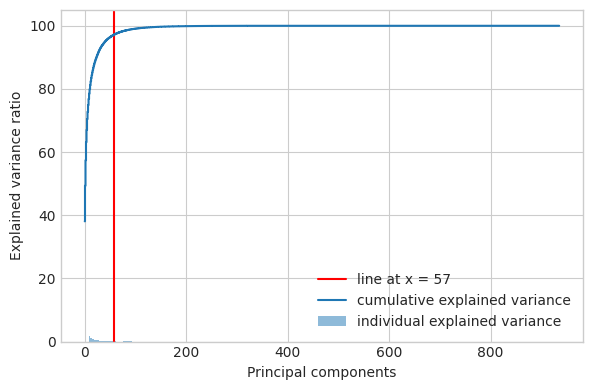

In [35]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=i, label='line at x = {}'.format(i), c='r')
    plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(len(table.columns)-1), cum_var_exp, where='mid',
             label='cumulative explained variance')
    
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig1.png', format='png', dpi=1200)
plt.show()

In [36]:
labels = np.unique(y, axis=0)

In [37]:
labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

### Data distribution in relevant components

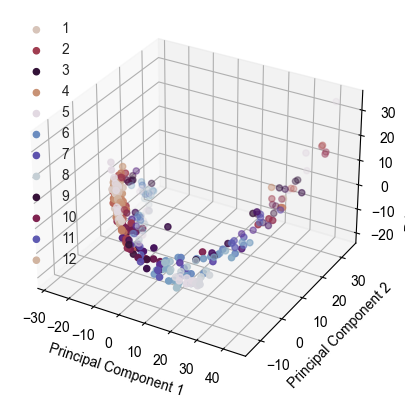

In [38]:
sklearn_pca = sklearnPCA(n_components=i)
Y_sklearn = sklearn_pca.fit_transform(X_std)

ax = plt.axes(projection='3d')
with plt.style.context('seaborn-whitegrid'):
#     plt.figure(figsize=(8, 6))
    for lab in labels:
#         plt.scatter(Y_sklearn[y==lab, 0],
#                     Y_sklearn[y==lab, 1],
#                     label=lab)
        zdata = Y_sklearn[y==lab, 2]
        xdata = Y_sklearn[y==lab, 0]
        ydata = Y_sklearn[y==lab, 1]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, label=lab, cmap='twilight');
#     plt.xlabel('Principal Component 1')
#     plt.ylabel('Principal Component 2')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    ax.legend(loc="best")
#     plt.legend(loc='best')
#     plt.tight_layout()
    plt.savefig(_path_1+'/Fig2.png', format='png', dpi=1200)
    plt.show()

### Variance of each component

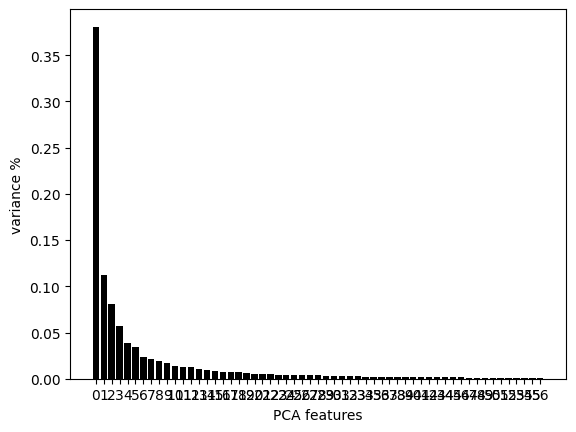

In [39]:
features = range(sklearn_pca.n_components_)
plt.bar(features, sklearn_pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.savefig(_path_1+'/Fig3.png', format='png', dpi=1200)
plt.show()

In [40]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(Y_sklearn)

In [41]:
PCA_components.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,-11.532879,-4.496665,10.556746,4.547160,1.614577,1.474351,-6.516662,-4.139394,-2.168091,-0.228068,...,-0.260763,-0.036021,-0.358955,0.614445,0.161947,0.126097,-0.344694,0.831709,-0.234288,-0.117744
1,-13.808324,-3.684183,10.878770,2.579102,-1.352376,2.989991,-2.085973,-4.072146,-4.883010,-0.883296,...,0.528241,-1.449997,-0.804007,-0.204690,-1.356607,2.164423,0.004533,-0.947915,-0.741516,0.977605
2,-14.499526,-2.111580,9.075049,-2.758884,-3.100996,3.204462,2.212679,-1.874294,-3.196374,-1.211271,...,0.776343,0.914464,-0.473959,0.140809,-1.088138,1.130439,0.243627,0.232460,-0.126255,1.047498
3,-20.984090,7.680375,5.147419,5.263307,-3.113281,3.266852,5.340833,9.227074,7.590759,2.540439,...,-1.072573,-1.598193,-0.512190,-0.807502,-0.000704,0.075984,-0.104384,-0.325074,0.987969,-0.392591
4,-21.405393,10.301445,2.122668,5.895995,-2.341111,4.676847,4.344519,14.715724,5.433336,0.652029,...,0.831167,-0.824641,-0.338161,-1.042794,-0.991503,0.657887,0.070005,0.841092,0.942997,0.122693


### Getting the optimal number of clusters

c:\Users\erik_\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\erik_\miniconda3\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\erik_\miniconda3\Lib\subprocess.py", line 1597, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\erik_\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for 

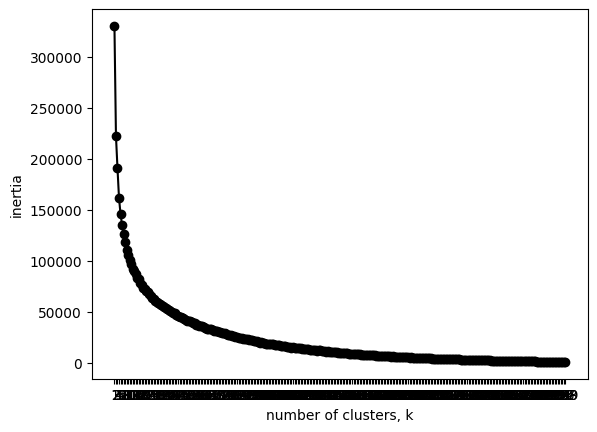

In [42]:
ks = range(1, max_cluster)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:i])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig(_path_1+'/Fig4.png', format='png', dpi=1200)
plt.show()

In [43]:
opt_cluster = 0
for k in range(len(inertias)-1):
    diff = abs(inertias[k]-inertias[k+1])/inertias[k]*100
    if diff > 0.1:
        opt_cluster += 1
    else:
        break
print("Optimal number of clusters: ", opt_cluster)

Optimal number of clusters:  72


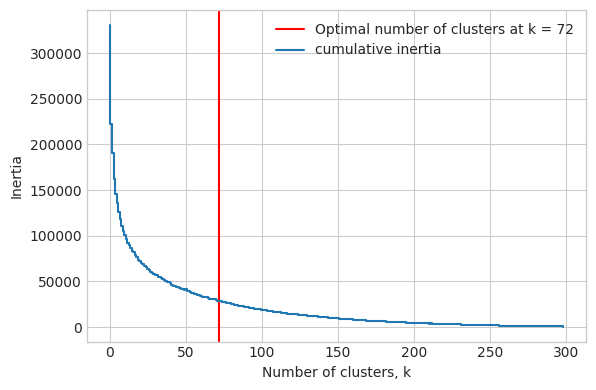

In [44]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    plt.axvline(x=opt_cluster, label='Optimal number of clusters at k = {}'.format(opt_cluster), c='r')
    # plt.bar(range(len(table.columns)-1), var_exp, alpha=0.5, align='center',
            # label='individual explained variance')
    plt.step(range(len(inertias)), inertias, where='mid',
             label='cumulative inertia')
    
    plt.ylabel('Inertia')
    plt.xlabel('Number of clusters, k')
    plt.legend(loc='best')
    plt.tight_layout()
plt.savefig(_path_1+'/Fig5.png', format='png', dpi=1200)
plt.show()

### %opt_cluster Five clusters are chosen, so we run K-medoids with number of clusters equals four.
### Same initializer and random state as before

In [45]:
#%% Clustering method
print("Clustering")
if cluster_method == 0:
    KMeansMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, data)
elif cluster_method == 1:
    results = KMedoidsMethod(opt_cluster, Y_sklearn, _path_0, _path_1, CaseName_Base, CaseName_ByStages, table, ddf_1)
print('End of the process...')

Clustering


c:\Users\erik_\miniconda3\Lib\site-packages\sklearn_extra\cluster\_k_medoids.py:243: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


End of the process...
